In [1]:
import torch
import torch.nn
import torch.nn.functional as F

In [2]:
from model.encoder import Encoder
from model.decoder import Decoder

In [19]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [251]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import skimage
from matplotlib import cm
import numpy as np
from dataset import get_dataset, collate_fn, vocab_size, int2char, char2int, SOS_CHAR, EOS_CHAR
from torch.utils.data import DataLoader
from torchvision import transforms
from utils import ScaleImageByHeight, AverageMeter, accuracy

In [252]:
config = {
    'batch_size': 32,
    'hidden_size': 256,
    'attn_size': 256,
    'max_length': 10,
    'n_epochs_decrease_lr': 15,
    'start_learning_rate': 1e-5,  # NOTE: paper start with 1e-8
    'end_learning_rate': 1e-11,
    'depth': 4,
    'n_blocks': 3,
    'growth_rate': 96,
}

In [253]:
MAX_LENGTH = config['max_length']
CKPT_DIR = './ckpt'

In [254]:
info = torch.load(os.path.join(CKPT_DIR, 'BEST_weights.pt'), map_location='cpu')

In [255]:
image_transform = transforms.Compose([
    transforms.Grayscale(3),
    ScaleImageByHeight(64),
    transforms.ToTensor(),
])

In [256]:
test_data = get_dataset('test', image_transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [257]:
encoder = Encoder(config['depth'], config['n_blocks'], config['growth_rate'])
if info['encoder_state'] is not None:
    encoder.load_state_dict(info['encoder_state'])

In [258]:
decoder = Decoder(encoder.n_features,
                  config['hidden_size'], vocab_size, config['attn_size'])
if info['decoder_state'] is not None:
    decoder.load_state_dict(info['decoder_state'])

In [259]:
encoder = encoder.to(device)
decoder = decoder.to(device)

In [260]:
encoder.eval()
decoder.eval();

In [261]:
test_iter = iter(test_loader)

In [295]:
imgs, targets, targets_onehot, lengths = next(test_iter)

In [296]:
imgs.size()

torch.Size([1, 3, 64, 84])

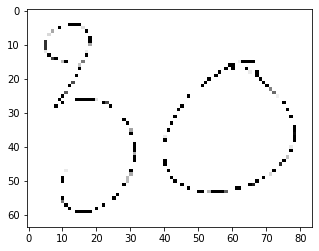

In [297]:
plt.imshow(imgs.squeeze().permute(1,2,0))

In [298]:
targets.size()

torch.Size([4, 1, 1])

In [299]:
''.join([int2char[x.item()] for x in targets.squeeze()])

'<start>30<end>'

In [300]:
start_input = torch.zeros(1, 1, vocab_size)
start_input[0,0, char2int[SOS_CHAR]] = 1
start_input

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [301]:
with torch.no_grad():
#     for i, (imgs, targets, targets_onehot, lengths) in enumerate(val_loader):
    img_features = encoder(imgs)
    outputs, weights = decoder.greedy(img_features, start_input)

In [302]:
outputs.size()

torch.Size([10, 1, 150])

In [303]:
_, index = outputs.topk(1, -1)

In [304]:
predicts = [int2char[x.item()] for x in index.squeeze()]
predicts

['<start>',
 '3',
 '0',
 '0',
 '<end>',
 '<end>',
 '<end>',
 '<end>',
 '<end>',
 '<end>']

In [305]:
predicts = predicts[:predicts.index(EOS_CHAR) + 1]
predicts

['<start>', '3', '0', '0', '<end>']

In [306]:
weights.size()

torch.Size([10, 1, 20])

In [307]:
img_rows, img_cols = imgs.size(2), imgs.size(3)
print(img_rows, img_cols)

64 84


In [308]:
length = len(predicts)
length

5

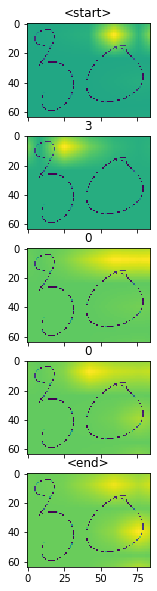

In [309]:
fig, axeses = plt.subplots(length, figsize=(10,10), sharex=True, sharey=True)
for i, axes in enumerate(axeses.ravel()):
    weight = weights[i].reshape(-1, 1, img_rows // 16, img_cols // 16) # 16 is factor that DenseNet reduce the original image size
    weight_numpy = weight.numpy().squeeze()
    weight_image = skimage.transform.resize(weight_numpy, (img_rows, img_cols))
    
    img = imgs.squeeze().permute(1,2,0).numpy()[:,:,0]
    
    alpha = 0.5
    blend = img * alpha + weight_image * (1-alpha)
    
    axes.title.set_text(predicts[i])
    axes.imshow(blend)
plt.plot();

In [293]:
weight = weights[0].reshape(-1, 1, img_rows // 16, img_cols // 16) # 16 is factor that DenseNet reduce the original image size
weight_numpy = weight.numpy().squeeze()
weight_image = skimage.transform.resize(weight_numpy, (img_rows, img_cols))